**Authorization**

In [2]:
import ee
ee.Authenticate()
ee.Initialize(project='ee-YOUR PROJECT NAME')

**Analysis**

Enter city name (as in GAUL, e.g., 'Delhi'): Bangalore Urban
Processing year: 2023
Descriptive Statistics:
       Metric       Mean     Median    StdDev
0    LST (°C)  35.918812  36.062331  2.256843
1  Albedo (%)  11.650057  11.250722  2.935910
2        NDVI   0.434550   0.441407  0.161514
3        NDBI  -0.041244  -0.027320  0.108923


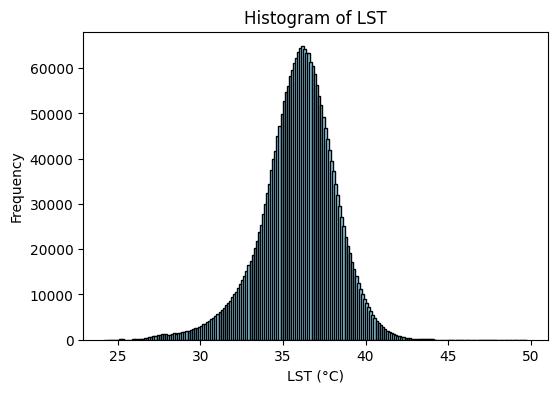

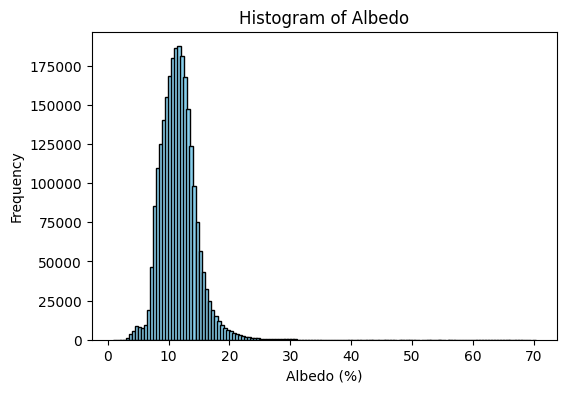

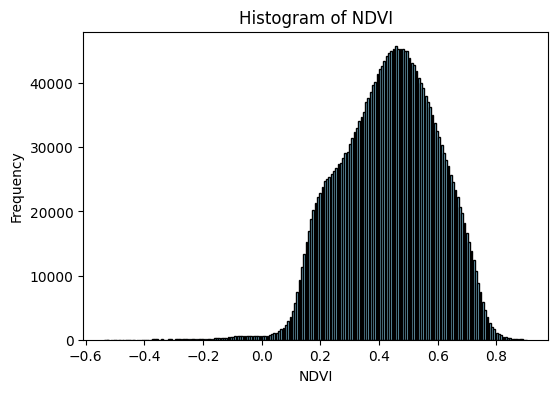

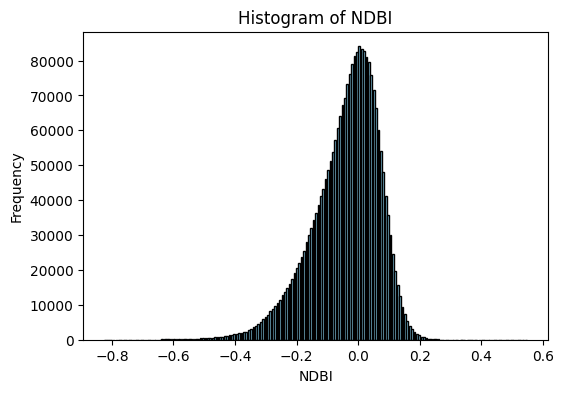

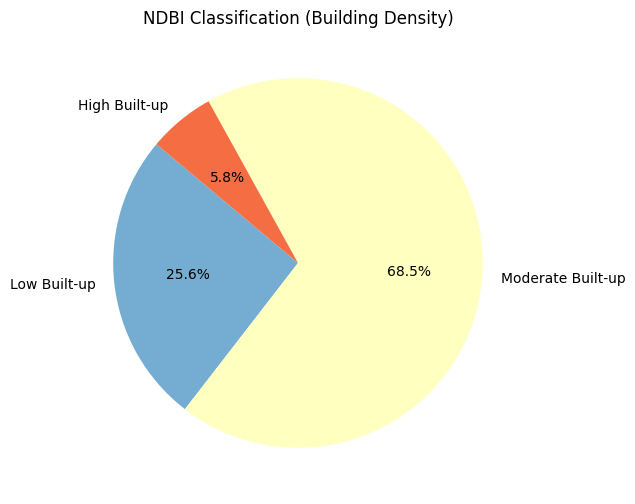

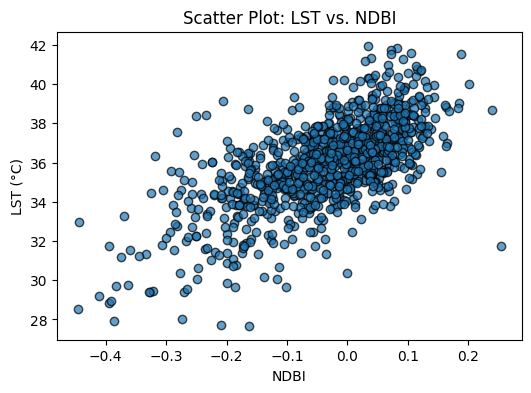

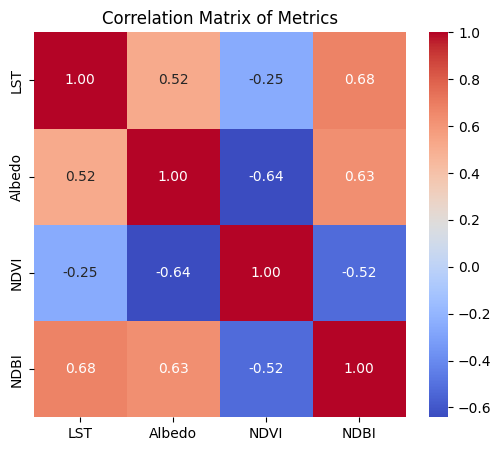

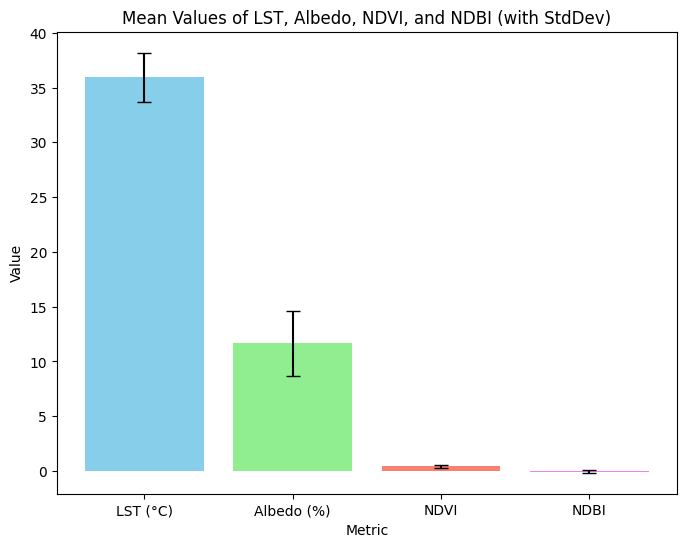

Risk Zone Percentages:
       Metric  Safe Zone (%)  Medium Risk (%)  High Risk (%)
0    LST (°C)            1.5             27.8           70.7
1        NDVI           35.3             55.3            9.4
2  Albedo (%)           99.9              0.1            0.0

Descriptive Statistics (for intuition):
       Metric       Mean     Median    StdDev
0    LST (°C)  35.918812  36.062331  2.256843
1  Albedo (%)  11.650057  11.250722  2.935910
2        NDVI   0.434550   0.441407  0.161514
3        NDBI  -0.041244  -0.027320  0.108923


In [ ]:
import ee
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ------------------------------
# 1. City Input & AOI Extraction
# ------------------------------
city_name = input("Enter city name (as in GAUL, e.g., 'Delhi'): ")

# Use GAUL administrative boundaries to extract the city boundary.
admin_boundaries = ee.FeatureCollection('FAO/GAUL/2015/level2')
city_boundary = admin_boundaries.filter(ee.Filter.eq('ADM2_NAME', city_name))
if city_boundary.size().getInfo() == 0:
    raise ValueError(f"City '{city_name}' not found. Please check the spelling.")
aoi = city_boundary.geometry()

# ------------------------------
# 2. Define Preprocessing & Calculation Functions
# ------------------------------
def apply_scale_factors(image):
    # Scale optical bands: Landsat 8 Collection 2 Level 2.
    optical_bands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)
    # Scale thermal band ST_B10 (for LST).
    thermal_band = image.select('ST_B10').multiply(0.00341802).add(149.0)
    image = image.addBands(thermal_band, None, True)
    return image.addBands(optical_bands, None, True)

def mask_l8sr(image):
    # Mask clouds and cloud shadows using the QA_PIXEL band.
    cloud_shadow_bit_mask = (1 << 3)
    clouds_bit_mask = (1 << 5)
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloud_shadow_bit_mask).eq(0).And(qa.bitwiseAnd(clouds_bit_mask).eq(0))
    return image.updateMask(mask)

def calculate_lst(image):
    # Calculate NDVI for emissivity estimation.
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    em = ndvi.expression(
        "(NDVIm < 0) ? 0.985 : (NDVIm > 0.7 ? 0.99 : 0.985 + 0.005 * NDVIm)",
        {'NDVIm': ndvi}
    ).rename('EM')
    thermal = image.select('ST_B10').rename('thermal')
    lst = thermal.expression(
        "(TB / (1 + (0.00115 * (TB / 1.438)) * log(EM))) - 273.15",
        {'TB': thermal, 'EM': em}
    ).rename('LST')
    return lst

def calculate_albedo(image):
    # Coefficients for computing surface albedo from Landsat 8 bands.
    coefficients = {
        'SR_B2': 0.356,
        'SR_B3': 0.130,
        'SR_B4': 0.373,
        'SR_B5': 0.085,
        'SR_B6': 0.072,
        'SR_B7': -0.0018
    }
    albedo = ee.Image(0)
    for band, coeff in coefficients.items():
        albedo = albedo.add(image.select(band).multiply(coeff))
    albedo = albedo.add(0.016).max(0).min(1).multiply(100).rename('albedo')
    return albedo

def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return ndvi

def calculate_ndbi(image):
    # NDBI = (SWIR1 - NIR)/(SWIR1 + NIR); for Landsat 8: SWIR1 = SR_B6, NIR = SR_B5.
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    return ndbi

def get_image_collection(year):
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'
    collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
                  .filterDate(start_date, end_date)
                  .filterBounds(aoi)
                  .filter(ee.Filter.lt('CLOUD_COVER', 20))
                  .map(apply_scale_factors)
                  .map(mask_l8sr))
    if collection.size().getInfo() == 0:
        raise ValueError(f"No Landsat 8 images found for {city_name} in {year}")
    return collection

# ------------------------------
# 3. Create Composite & Compute Metrics for a Selected Year
# ------------------------------
year = '2023'
print(f"Processing year: {year}")
collection = get_image_collection(year)
median_image = collection.median()

lst_image    = calculate_lst(median_image).clip(aoi)
albedo_image = calculate_albedo(median_image).clip(aoi)
ndvi_image   = calculate_ndvi(median_image).clip(aoi)
ndbi_image   = calculate_ndbi(median_image).clip(aoi)

# ------------------------------
# 4. Visualize on a Folium Map (Result Layers)
# ------------------------------
lst_vis = {'min': 25, 'max': 50, 'palette': ['#040274', '#32d3ef', '#fff705', '#ff0000']}
albedo_vis = {'min': 0, 'max': 60, 'palette': ['#2C1A5A', '#F2E627', '#FFFFFF']}
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['#d73027', '#ffffbf', '#1a9850']}
ndbi_vis = {'min': -0.5, 'max': 0.5, 'palette': ['#313695', '#74add1', '#ffffbf', '#f46d43', '#a50026']}

city_center = aoi.centroid().coordinates().getInfo()
Map = folium.Map(location=[city_center[1], city_center[0]], zoom_start=11)

def add_ee_layer(image, vis_params, name):
    map_id_dict = ee.Image(image).getMapId(vis_params)
    folium.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(Map)

add_ee_layer(lst_image, lst_vis, f'LST {year}')
add_ee_layer(albedo_image, albedo_vis, f'Albedo {year}')
add_ee_layer(ndvi_image, ndvi_vis, f'NDVI {year}')
add_ee_layer(ndbi_image, ndbi_vis, f'NDBI {year}')

folium.LayerControl().add_to(Map)
Map  # This displays the interactive map

# ------------------------------
# 5. Generate Descriptive Statistics Table
# ------------------------------
def get_stats(image, band_name, geometry, scale=30):
    reducers = ee.Reducer.mean().combine(ee.Reducer.median(), '', True)\
              .combine(ee.Reducer.stdDev(), '', True)
    stats = image.select(band_name).reduceRegion(
        reducer=reducers, geometry=geometry, scale=scale, maxPixels=1e9)
    return stats.getInfo()

stats_lst    = get_stats(lst_image, 'LST', aoi)
stats_albedo = get_stats(albedo_image, 'albedo', aoi)
stats_ndvi   = get_stats(ndvi_image, 'NDVI', aoi)
stats_ndbi   = get_stats(ndbi_image, 'NDBI', aoi)

data = {
    'Metric': ['LST (°C)', 'Albedo (%)', 'NDVI', 'NDBI'],
    'Mean': [stats_lst.get('LST_mean'), stats_albedo.get('albedo_mean'),
             stats_ndvi.get('NDVI_mean'), stats_ndbi.get('NDBI_mean')],
    'Median': [stats_lst.get('LST_median'), stats_albedo.get('albedo_median'),
               stats_ndvi.get('NDVI_median'), stats_ndbi.get('NDBI_median')],
    'StdDev': [stats_lst.get('LST_stdDev'), stats_albedo.get('albedo_stdDev'),
               stats_ndvi.get('NDVI_stdDev'), stats_ndbi.get('NDBI_stdDev')]
}
df_stats = pd.DataFrame(data)
print("Descriptive Statistics:")
print(df_stats)

# ------------------------------
# 6. Histograms for Each Metric
# ------------------------------
def get_histogram(image, band_name, geometry, scale=30, maxPixels=1e9):
    histogram = image.select(band_name).reduceRegion(
        reducer=ee.Reducer.histogram(), geometry=geometry, scale=scale, maxPixels=maxPixels)
    return histogram.get(band_name).getInfo()

hist_lst    = get_histogram(lst_image, 'LST', aoi)
hist_albedo = get_histogram(albedo_image, 'albedo', aoi)
hist_ndvi   = get_histogram(ndvi_image, 'NDVI', aoi)
hist_ndbi   = get_histogram(ndbi_image, 'NDBI', aoi)

def plot_histogram(hist_data, title, xlabel):
    bins = hist_data['bucketMeans']
    counts = hist_data['histogram']
    plt.figure(figsize=(6,4))
    plt.bar(bins, counts, width=(bins[1]-bins[0]) if len(bins)>1 else 1,
            color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(hist_lst, "Histogram of LST", "LST (°C)")
plot_histogram(hist_albedo, "Histogram of Albedo", "Albedo (%)")
plot_histogram(hist_ndvi, "Histogram of NDVI", "NDVI")
plot_histogram(hist_ndbi, "Histogram of NDBI", "NDBI")

# ------------------------------
# 7. Pie Chart: NDBI Classification
# ------------------------------
def classify_ndbi(ndbi_img):
    # Classify pixels based on thresholds:
    # Class 1: Low built-up (NDBI < -0.1)
    # Class 2: Moderate built-up (-0.1 <= NDBI < 0.1)
    # Class 3: High built-up (NDBI >= 0.1)
    classified = ndbi_img.expression(
        "b('NDBI') < -0.1 ? 1 : (b('NDBI') < 0.1 ? 2 : 3)"
    ).rename('NDBI_Class')
    return classified

ndbi_class = classify_ndbi(ndbi_image)
freq = ndbi_class.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(), geometry=aoi, scale=30, maxPixels=1e9)
freq_dict = freq.get('NDBI_Class').getInfo()

total_pixels = sum(freq_dict.values())
labels = []
sizes = []
for key in sorted(freq_dict.keys(), key=lambda x: int(x)):
    if key == '1':
        labels.append("Low Built-up")
    elif key == '2':
        labels.append("Moderate Built-up")
    elif key == '3':
        labels.append("High Built-up")
    sizes.append(freq_dict[key] / total_pixels * 100)

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
        colors=['#74add1','#ffffbf','#f46d43'])
plt.title("NDBI Classification (Building Density)")
plt.show()

# ------------------------------
# 8. Scatter Plot: LST vs. NDBI
# ------------------------------
sample = lst_image.addBands(ndbi_image).sample(
    region=aoi, numPixels=1000, scale=30, seed=1)
sample_features = sample.getInfo()['features']

lst_values = []
ndbi_values = []
for feat in sample_features:
    props = feat['properties']
    if 'LST' in props and 'NDBI' in props:
        lst_values.append(props['LST'])
        ndbi_values.append(props['NDBI'])

plt.figure(figsize=(6,4))
plt.scatter(ndbi_values, lst_values, alpha=0.7, edgecolor='k')
plt.xlabel("NDBI")
plt.ylabel("LST (°C)")
plt.title("Scatter Plot: LST vs. NDBI")
plt.show()

# ------------------------------
# 9. Correlation Matrix: All Metrics
# ------------------------------
combined_sample = lst_image.addBands(albedo_image).addBands(ndvi_image)\
                           .addBands(ndbi_image).sample(
                               region=aoi, numPixels=1000, scale=30, seed=42)
sample_features = combined_sample.getInfo()['features']

data_list = []
for feat in sample_features:
    props = feat['properties']
    if all(k in props for k in ['LST', 'albedo', 'NDVI', 'NDBI']):
        data_list.append({
            'LST': props['LST'],
            'Albedo': props['albedo'],
            'NDVI': props['NDVI'],
            'NDBI': props['NDBI']
        })

df_metrics = pd.DataFrame(data_list)
corr_matrix = df_metrics.corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Metrics")
plt.show()

# ------------------------------
# 10. Bar Chart: Mean Values with Error Bars
# ------------------------------
metrics = df_stats['Metric']
means = df_stats['Mean']
std_devs = df_stats['StdDev']

plt.figure(figsize=(8,6))
plt.bar(metrics, means, yerr=std_devs, color=['skyblue', 'lightgreen', 'salmon', 'violet'], capsize=5)
plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Mean Values of LST, Albedo, NDVI, and NDBI (with StdDev)")
plt.show()

# ------------------------------
# 11. Risk Zone Table: High, Medium, and Safe Zones
# ------------------------------
def compute_risk_percentages(image, band_name, thresholds, geometry, scale=30, numPixels=1000, seed=42):
    """
    Computes the percentage of pixels in three risk zones for a given metric.

    For LST and Albedo:
      - Safe Zone: values below the lower threshold.
      - Medium Risk: values between lower and upper thresholds.
      - High Risk: values above the upper threshold.

    For NDVI (higher values are safer):
      - Safe Zone: values above the upper threshold.
      - Medium Risk: values between the lower and upper thresholds.
      - High Risk: values below the lower threshold.

    thresholds: tuple (lower_threshold, upper_threshold)
    """
    sample = image.select(band_name).sample(region=geometry, numPixels=numPixels, scale=scale, seed=seed)
    sample_info = sample.getInfo()['features']
    values = [feat['properties'][band_name] for feat in sample_info if band_name in feat['properties']]
    values = np.array(values)
    total = len(values)
    if total == 0:
        return (None, None, None)
    low_thresh, high_thresh = thresholds
    if band_name == 'NDVI':
        safe = np.sum(values > high_thresh)
        medium = np.sum((values <= high_thresh) & (values >= low_thresh))
        high = np.sum(values < low_thresh)
    else:
        safe = np.sum(values < low_thresh)
        medium = np.sum((values >= low_thresh) & (values < high_thresh))
        high = np.sum(values >= high_thresh)
    return safe/total*100, medium/total*100, high/total*100

# Define thresholds (example values; adjust as needed):
lst_thresholds = (30, 35)           # For LST: Safe: <30°C, Medium: 30-35°C, High: ≥35°C.
ndvi_thresholds = (0.2, 0.5)          # For NDVI: Safe: >0.5, Medium: 0.2-0.5, High: <0.2.
albedo_thresholds = (30, 50)          # For Albedo: Safe: <30%, Medium: 30-50%, High: ≥50%.

lst_risk = compute_risk_percentages(lst_image, 'LST', lst_thresholds, aoi)
ndvi_risk = compute_risk_percentages(ndvi_image, 'NDVI', ndvi_thresholds, aoi)
albedo_risk = compute_risk_percentages(albedo_image, 'albedo', albedo_thresholds, aoi)

risk_data = {
    'Metric': ['LST (°C)', 'NDVI', 'Albedo (%)'],
    'Safe Zone (%)': [lst_risk[0], ndvi_risk[0], albedo_risk[0]],
    'Medium Risk (%)': [lst_risk[1], ndvi_risk[1], albedo_risk[1]],
    'High Risk (%)': [lst_risk[2], ndvi_risk[2], albedo_risk[2]]
}
risk_df = pd.DataFrame(risk_data)
print("Risk Zone Percentages:")
print(risk_df)

# ------------------------------
# 12. Additional Intuitive Table: Descriptive Statistics (already printed above)
# ------------------------------
print("\nDescriptive Statistics (for intuition):")
print(df_stats)
